Importing the Bert tokenizer and showing an example embedding generated from it

In [1]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text, padding='max_length', max_length = 10, truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

/Users/ben/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


Sets up the classification labels and data loader for parsing dataset

In [2]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'RDC':0,
          'AMB':1,
          }


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['LQ Code']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Excerpt']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Imports the data used for training and validation into a dataframe named df_for_training

In [3]:
import pandas as pd
df_for_training = pd.read_csv('mixeddataset1.csv') # enter the path to the dataset used for training here
df_for_training['Excerpt'] = df_for_training['Excerpt'].replace(",", "", regex=True)
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       147 non-null    int64 
 1   Excerpt  147 non-null    object
 2   SY1      147 non-null    object
 3   SY2      142 non-null    object
 4   CO1      147 non-null    object
 5   CO2      141 non-null    object
 6   LQ Code  147 non-null    object
 7   Comment  63 non-null     object
dtypes: int64(1), object(7)
memory usage: 9.3+ KB


Imports the data used for testing into a dataframe named df_test

In [4]:
df_test = pd.read_csv('mixeddataset2.csv') # enter the path to the dataset used for testing here
df_test['Excerpt'] = df_test['Excerpt'].replace(",", "", regex=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       30 non-null     int64 
 1   Excerpt  30 non-null     object
 2   SY1      30 non-null     object
 3   SY2      28 non-null     object
 4   CO1      30 non-null     object
 5   CO2      28 non-null     object
 6   LQ Code  30 non-null     object
 7   Comment  14 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.0+ KB


Removes duplicates from the df_for_training dataset that is within the df_test dataset

In [5]:
df_for_training = df_for_training[~df_for_training['Excerpt'].isin(df_test['Excerpt'])]
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       147 non-null    int64 
 1   Excerpt  147 non-null    object
 2   SY1      147 non-null    object
 3   SY2      142 non-null    object
 4   CO1      147 non-null    object
 5   CO2      141 non-null    object
 6   LQ Code  147 non-null    object
 7   Comment  63 non-null     object
dtypes: int64(1), object(7)
memory usage: 9.3+ KB


Splits the data used for training and validation into separate dataframes 

In [6]:
np.random.seed(112)
df_train, df_val, df_test_not_used = np.split(df_for_training.sample(frac=1, random_state=42), 
                                     [int(.8*len(df_for_training)), int(.9*len(df_for_training))])

print(len(df_train),len(df_val), len(df_test))
print("-----------------------df_train---------------------------")
df_train.info()
df_train.groupby('LQ Code').describe()

117 15 30
-----------------------df_train---------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 125 to 59
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       117 non-null    int64 
 1   Excerpt  117 non-null    object
 2   SY1      117 non-null    object
 3   SY2      113 non-null    object
 4   CO1      117 non-null    object
 5   CO2      112 non-null    object
 6   LQ Code  117 non-null    object
 7   Comment  47 non-null     object
dtypes: int64(1), object(7)
memory usage: 8.2+ KB


/Users/ben/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


ID                                                            
        count        mean        std    min     25%    50%     75%    max
LQ Code                                                                  
AMB      47.0  147.787234  17.657288  115.0  133.50  149.0  162.50  176.0
RDC      70.0   42.214286  24.752627    1.0   20.75   42.0   63.75   84.0

In [7]:
print("-----------------------df_val---------------------------")
df_val.info()
df_val.groupby('LQ Code').describe()

-----------------------df_val---------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 91 to 1
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       15 non-null     int64 
 1   Excerpt  15 non-null     object
 2   SY1      15 non-null     object
 3   SY2      14 non-null     object
 4   CO1      15 non-null     object
 5   CO2      14 non-null     object
 6   LQ Code  15 non-null     object
 7   Comment  6 non-null      object
dtypes: int64(1), object(7)
memory usage: 1.1+ KB


ID                                                           
        count        mean        std    min     25%    50%    75%    max
LQ Code                                                                 
AMB       6.0  140.000000  24.240462  119.0  121.25  130.0  160.5  172.0
RDC       9.0   42.111111  21.928546    2.0   33.00   42.0   58.0   76.0

In [8]:
print("-----------------------df_test---------------------------")
df_test.info()
df_test.groupby('LQ Code').describe()

-----------------------df_test---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       30 non-null     int64 
 1   Excerpt  30 non-null     object
 2   SY1      30 non-null     object
 3   SY2      28 non-null     object
 4   CO1      30 non-null     object
 5   CO2      28 non-null     object
 6   LQ Code  30 non-null     object
 7   Comment  14 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.0+ KB


ID                                                      
        count   mean       std    min     25%    50%     75%    max
LQ Code                                                            
AMB      14.0  107.5  4.183300  101.0  104.25  107.5  110.75  114.0
RDC      16.0   92.5  4.760952   85.0   88.75   92.5   96.25  100.0

Constructor for the neural network object

In [9]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer


Training loop of the model (read comments at the bottom of the code block!)

In [10]:
from torch.optim import Adam
from tqdm import tqdm
import sklearn 

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss() # eddit the weigth parameter of the model to help with particular classes that are not being correctly predicted
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay=0.01) # edit weight_decay to help with overfitting

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
model = BertClassifier()
EPOCHS = 1 # lower the epocs if you are using a cpu or are NOT using a gpu stronger than a 4090 (for reference it takes roughly 1 hour to train the model on an A6000)
LR = 1e-5 # adjusting learning rate can help with accuracy 

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 59/59 [07:49<00:00,  7.95s/it]


Epochs: 1 | Train Loss:  0.783                 | Train Accuracy:  0.453                 | Val Loss:  0.643                 | Val Accuracy:  0.667


Function to generate multilabel confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
import itertools 
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')


Testing loop for the model

will show:

- accuracy, precision, recall, and F1 scores of the model on the testing dataset

- each sentence it predicted incorrectly along with the prediction it made instead

- a multi-label confusion matrix to show how each class performed

AMB (true) -> RDC (pred): The system shall provide a secure login feature with two-factor authentication.
AMB (true) -> RDC (pred): The application must ensure that user input is validated before processing.
AMB (true) -> RDC (pred): The system should support multiple user roles and permissions.
AMB (true) -> RDC (pred): The system should support real-time notifications for all user activities.
AMB (true) -> RDC (pred): The software product needs to provide efficient data storage and retrieval mechanisms.
AMB (true) -> RDC (pred): The application shall allow users to export data into various file formats.
AMB (true) -> RDC (pred): The system should provide a seamless integration with third-party APIs.
AMB (true) -> RDC (pred): The software must maintain consistency across all user interfaces.
AMB (true) -> RDC (pred): The system should ensure data privacy and compliance with GDPR regulations.
AMB (true) -> RDC (pred): The system shall provide user data access.
AMB (true) -> RDC (pred):

{'Accuracy:  0.567', 'F1 Score:  0.441', 'Percision:  0.761', 'Recall:  0.567'}

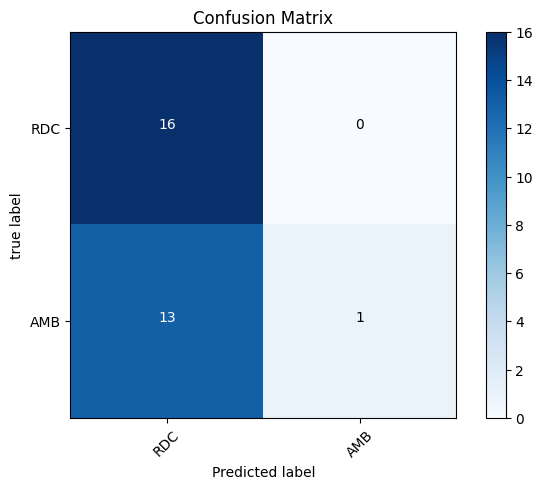

In [12]:
from pandas import DataFrame
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)

def evaluate(model, test_data: DataFrame):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    test_pred = []
    test_true = []
    test_class = test_data['LQ Code'].tolist()
    test_sentence = test_data['Excerpt'].tolist()
    test_pred_class = ['RDC','AMB']

    with torch.no_grad():
    
        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              _, predicted = torch.max(output.data, 1)
              test_pred.extend(predicted.cpu().numpy())
              test_true.extend(test_label.cpu().numpy())
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    for i in range(len(test_pred)):
        if(test_true[i] != test_pred[i]):
            print(test_class[i] + " (true) -> " + test_pred_class[test_pred[i]] + " (pred): " + test_sentence[i] )

    cm = confusion_matrix(test_true, test_pred)
    cm_plot_labels = ['RDC','AMB']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
    return {f"Accuracy: {total_acc_test / len(test_data): .3f}",
             f"F1 Score: {f1_score(test_true, test_pred, average='weighted'): .3f}", 
             f"Percision: {precision_score(test_true, test_pred, average='weighted'): .3f}",
             f"Recall: {recall_score(test_true, test_pred, average='weighted'): .3f}"}
    
evaluate(model, df_test)